In [35]:
from shapely.geometry import *
from shapely.affinity import *
from shapely.ops import *

import matplotlib.pyplot as plt
import numpy as np

# Install gdal according to python version: GDAL-3.4.2-cp39-cp39-win_amd64.whl
# Install fiona according to python version: https://www.lfd.uci.edu/~gohlke/pythonlibs/#fiona
import geopandas as gpd

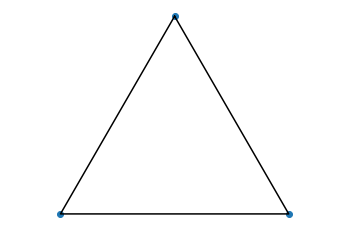

In [36]:
# import shapely.geometry as sg
# import shapely.affinity as sa

n = 3
k = 3
ori = Point([0, 0])
p = [Point([0, 1])]

for side in range(1, n):
    p.append(rotate(p[-1], 360/n, origin=ori))  # shaply.affinity.rotate
ngon = Polygon(p)

plt.figure()
plt.plot(*ngon.exterior.xy, "-k")

plt.scatter(*np.transpose([ngon.exterior.interpolate(t).xy for t in np.linspace(0, ngon.length, k, False)])[0])

plt.axis("equal")
plt.box("off")
plt.axis("off")
plt.show(block=0)


In [37]:
npts = 3;int(ngon.length/0.25)
pts = [ngon.exterior.interpolate(t).xy for t in np.linspace(0, ngon.length, npts)]
# MultiPoint(np.transpose(pts)[0])
# np.transpose(pts)[0]
pts

[(array('d', [0.0]), array('d', [1.0])),
 (array('d', [1.1102230246251565e-16]), array('d', [-0.5000000000000001])),
 (array('d', [0.0]), array('d', [1.0]))]

In [38]:
c1 = Point(0, 0).buffer(5)
c2 = Point(1, 0).buffer(5)
print(f"c1: {c1.area:0.2f} m2, c2: {c2.area:0.2f} m2, c1+c2: {c1.area+c2.area:0.2f}")

c1: 78.41 m2, c2: 78.41 m2, c1+c2: 156.83


intersection(c1, c2): 68.44 m2
union(c1, c2): 88.39 m2
symmetric_difference(c1, c2): 19.95 m2
difference(c1, c2): 9.98 m2


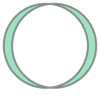

In [39]:
print(f"intersection(c1, c2): {c1.intersection(c2).area:0.2f} m2")  # common area between two circles
print(f"union(c1, c2): {c1.union(c2).area:0.2f} m2")  # total area
print(f"symmetric_difference(c1, c2): {c1.symmetric_difference(c2).area:0.2f} m2")  # total area except the overlap
print(f"difference(c1, c2): {c1.difference(c2).area:0.2f} m2")  # Subtract the c2 from c1 and result the remaining shape.
c1.symmetric_difference(c2)
# c1.difference(c2)  

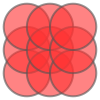

In [40]:
# Multipile polygon
lst = []
for x in range(0, 3):
    for y in range(0, 3):
        lst.append(Point(x, y).buffer(1))
        
mpg = MultiPolygon(lst)
# unary_union(mpg)  # Total scan area
mpg

<ipython-input-41-fb8a93335fe8>:3: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pg in mpg:


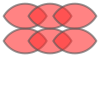

In [41]:
prev = None
ist = []
for pg in mpg:
    if prev is None:
        prev = pg
    else:
        # ist = pg.symmetric_difference(ist)
        ist.append(prev.intersection(pg))
        prev = pg

ist = MultiPolygon(ist)
# unary_union(ist)
ist

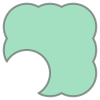

In [42]:
temp = unary_union(mpg)
temp1 = temp.difference(Point(0,0).buffer(1))
temp1

<AxesSubplot:>

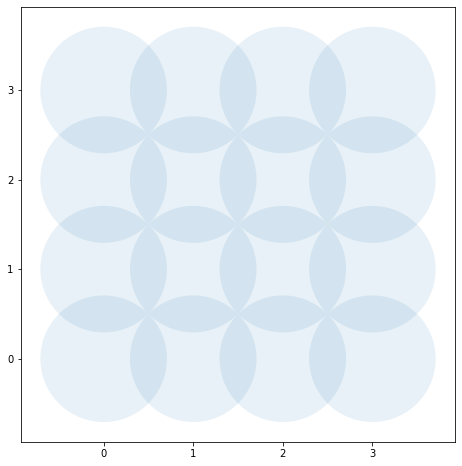

In [43]:
lst = []
for x in range(0, 4):
    for y in range(0, 4):
        lst.append(Point(x, y).buffer(0.707))     
gdf = gpd.GeoDataFrame({'geometry': gpd.GeoSeries(lst)})
gdf.plot(alpha=0.1, figsize=(16, 8))

<ipython-input-44-7bccc999b33a>:13: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  merged_cells = unary_union([mpg[pos] for pos in idx.intersection(poly.bounds)])


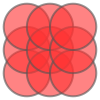

In [44]:
from rtree import index
idx = index.Index()

# Populate R-tree index with bounds of grid cells
for pos, cell in enumerate(mpg.geoms):
    # assuming cell is a shapely object
    idx.insert(pos, cell.bounds)
    
# Loop through each Shapely polygon
lst = []
for poly in mpg.geoms:
    # Merge cells that have overlapping bounding boxes
    merged_cells = unary_union([mpg[pos] for pos in idx.intersection(poly.bounds)])
    # Now do actual intersection
    lst.append(poly.intersection(merged_cells))
    
MultiPolygon(lst)

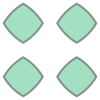

In [45]:
c00 = Point(0, 0).buffer(1)
c01 = Point(0, 1).buffer(1)
c02 = Point(0, 2).buffer(1)
c0 = c01.intersection(c00.union(c02)) 

c10 = Point(1, 0).buffer(1)
c11 = Point(1, 1).buffer(1)
c12 = Point(1, 2).buffer(1)
c1 = c11.intersection(c10.union(c12)) 

c20 = Point(2, 0).buffer(1)
c21 = Point(2, 1).buffer(1)
c22 = Point(2, 2).buffer(1)
c2 = c21.intersection(c20.union(c22)) 

c1.intersection(c0.union(c2))  # Region with 4 overlapping circles


In [46]:
from sklearn.neighbors import KDTree
import numpy as np
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
kdt = KDTree(X, leaf_size=30, metric='euclidean')
# dist, idx = kdt.query(X[:1], k=3, return_distance=True) # Return distance and index of the three neighbours
idx, dist = kdt.query_radius(X[:1], r=5, return_distance=True, count_only=False) # Return distance and index within radius
print(dist)
print(idx)
# kdt.query_radius(X[:1], r=1, count_only=True, sort_results=True) # Return distance and index within radius


[array([0.        , 1.        , 2.23606798, 2.82842712, 3.60555128,
        5.        ])                                               ]
[array([0, 1, 2, 3, 4, 5])]


In [47]:
radius = 1
centers = [[x,y] for x in range(0, 3, radius) for y in range(0, 3, radius)]
kdt = KDTree(centers, leaf_size=30, metric='euclidean')
idx, dist = kdt.query_radius([centers[0]], r=2*radius, count_only=False, return_distance=True, sort_results=True)
print(idx.tolist())
print(dist)

[array([0, 3, 1, 4, 2, 6])]
[array([0.        , 1.        , 1.        , 1.41421356, 2.        ,
        2.        ])                                               ]


In [1]:
import open_street_map as osm

In [2]:
# gdf, bbox, pgx = osm.get_holes_and_bbox((51.89030, 10.41933), 100, 10)
gdf, bbox, pgx = osm.get_holes_and_bbox((49.81051384510241, 9.988340883784735), 100, 10)


/home/ahmad/.local/lib/python3.8/site-packages/geopandas/geoseries.py:923: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():


In [5]:
pgx1 = osm.inflate_holes(pgx, 15, False)

Multipolygon 


TypeError: 'Polygon' object is not iterable